# **Segunda entrega monografía**

**Integrantes:**
- Alan Stiven Camacho Restrepo
- Isabel Cristina Suárez Roldán.

In [1]:
# Importacion de librerias necesarias para el proyecto
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Lista vacía para guardar los DataFrames
dfs = []

# Leer archivos del 0 al 10 y agregarlos a la lista
for i in range(11):
    file_name = f"base_variables_totales_parte{i}.parquet"
    df = pd.read_parquet(file_name)
    dfs.append(df)

In [3]:
# Tabla final: Unir todos los DataFrames en uno solo
df_final = pd.concat(dfs, ignore_index=True)

In [4]:
# Tamaño de la tabla
df_final.shape

(1598523, 92)

In [5]:
df_final.head()

,fecha_orden,year,month,tipo_doc,cod_estado_cli,num_doc,cod_segm,dias_mora,desempleado,ingreso_final_smmlv,...,flag_estabilidad_6m_asto_total,flag_retiro_efectivo_bajo_ingreso_final,flag_retiro_efectivo_bajo_estimadores,cupo_smmlv,val_trx_cop_compra_smmlv,val_trx_cop_avance_smmlv,flag_avances_cupo_uso_tdc,razon_trx_max_una_cuota_ingreso_estimadores,flag_mal_uso_tdc_trx_max_ingreso_estimadores,valor_g
0,202104,2021,4,1,1,045b809be3,4,NaN,1.0,0.039338,...,1,0,0,None,None,None,0,None,0,G7
1,202402,2024,2,1,1,f25a890f5a,4,NaN,0.0,0.000000,...,1,0,0,None,None,None,0,None,0,G1
2,202408,2024,8,1,1,d58acc33de,M,178.0,NaN,0.000000,...,1,0,0,0.25384615384615385,None,None,0,None,0,G8
3,202210,2022,10,1,1,c1325d3a5b,4,0.0,NaN,0.480417,...,1,1,1,None,None,None,0,None,0,G5
4,202207,2022,7,1,1,1980a06c65,4,NaN,0.0,3.585892,...,1,0,0,None,None,None,0,None,0,G4


# Descripción de la tabla final

La tabla final es una base consolidada y anonimizada que resume el comportamiento financiero mensual de clientes del banco entre agosto de 2021 y marzo de 2025. Integra información de ingresos, gastos, productos financieros, uso de canales, estabilidad económica y riesgo crediticio. Contiene variables originales y derivadas, construidas a partir de 12 tablas cruzadas por cliente y fecha, con múltiples transformaciones, agregaciones y banderas (flags) para facilitar el análisis prescriptivo y la personalización del score crediticio.


In [6]:
def boxplots_univariados_multiples(df: pd.DataFrame, columnas: list, n_cols: int = 3) -> None:
    """
    Grafica múltiples boxplots para variables numéricas.

    Args:
        df (pd.DataFrame): DataFrame con los datos.
        columnas (list): Lista de nombres de columnas numéricas a graficar.
        n_cols (int): Número de columnas por fila en la visualización.
    """
    n = len(columnas)
    n_rows = -(-n // n_cols)  # Redondeo hacia arriba

    plt.figure(figsize=(5 * n_cols, 4 * n_rows))

    for i, col in enumerate(columnas, 1):
        plt.subplot(n_rows, n_cols, i)
        if pd.api.types.is_numeric_dtype(df[col]):
            sns.boxplot(y=df[col])
            plt.title(f"Boxplot: {col}")
            plt.tight_layout()
        else:
            plt.text(0.5, 0.5, f"{col}\n(no numérica)", ha='center', va='center')
            plt.axis('off')

    plt.suptitle("Boxplots univariados", fontsize=16, y=1.02)
    plt.show()


### Definición de columnas

In [6]:
columnas_no_importantes = ['fecha_orden', 'year', 'month', 'tipo_doc', 'cod_estado_cli', 'num_doc',
       'cod_segm']

In [30]:
columnas_no_utilizadas = [
    'fuente_ingreso_final_smmlv', 'supervivencia', 'probabilidad_contagio', 'potencial_contagio_mes',
    'susceptibilidad_mes', 'flag_regla_sobreendeudamiento', 'flag_regla_sobreendeudamiento_ce_ingreso_estimadores',
    'flag_regla_sobreendeudamiento_ci_ingreso_estimadores',
    'flag_regla_sobreendeudamiento_total_ingreso_estimadores', 'flag_regla_capacidad_pago', 'regla_razon_sobreendeudamiento',
    'regla_capacidad_pago'
]

In [31]:
columnas_dicotomicas = [
    'desempleado', 'flag_compras_basicas',
    'flag_compras_no_basicas', 'flag_inversiones',
    'flag_sobreendeudamiento_ce', 'flag_sobreendeudamiento_ci',
    'flag_sobreendeudamiento_total',
    'flag_capacidad_pago_ce', 'flag_capacidad_pago_ci',
    'flag_capacidad_pago_total',
    'flag_capacidad_pago_ce_estimadores',
    'flag_capacidad_pago_ci_estimadores',
    'flag_capacidad_pago_total_estimadores', 'estabilidad_mensual',
    'estabilidad_mensual_estimadores', 'flag_estabilidad_ingreso',
    'flag_estabilidad_ingreso_estimadores', 'flag_cuenta_cero',
    'flag_cliente_ahorra', 'flag_cliente_ahorra_estimadores',
    'flag_estabilidad_mensual_compras_basicas',
    'flag_estabilidad_mensual_compras_no_basicas',
    'flag_estabilidad_mensual_suma_basicas_no_basicas',
    'flag_estabilidad_mensual_gasto_total',
    'flag_estabilidad_6m_compras_basicas',
    'flag_estabilidad_6m_compras_no_basicas',
    'flag_estabilidad_6m_suma_basicas_no_basicas',
    'flag_estabilidad_6m_asto_total',
    'flag_retiro_efectivo_bajo_ingreso_final',
    'flag_retiro_efectivo_bajo_estimadores',
    'flag_avances_cupo_uso_tdc',
    'flag_mal_uso_tdc_trx_max_ingreso_estimadores'
]

In [32]:
len(columnas_dicotomicas)

32

In [9]:
columna_categorica = ["valor_g"]

In [10]:
columnas_numericas = list(set(df_final.columns) - (set(columnas_no_importantes) | set(columnas_no_utilizadas) | set(columnas_dicotomicas) | set(columna_categorica)))

In [21]:
len(columnas_numericas)

40

In [16]:
columnas_numericas = [
    # 1. Cuotas / Endeudamiento
        'cuota_total_ce_smmlv',
        'cuota_total_ci_smmlv',
        'razon_sobreendeudamiento_ce',
        'razon_sobreendeudamiento_ci',
        'razon_sobreendeudamiento_total',
        'razon_sobreendeudamiento_ce_ingreso_estimadores',
        'razon_sobreendeudamiento_ci_ingreso_estimadores',
        'razon_sobreendeudamiento_total_ingreso_estimadores',

    # 2. Capacidad de pago
        'capacidad_pago_ce',
        'capacidad_pago_ci',
        'capacidad_pago_total',
        'capacidad_pago_ce_estimadores',
        'capacidad_pago_ci_estimadores',
        'capacidad_pago_total_estimadores',

    # 3. Ingresos / Estimaciones / Cupo
        'ingreso_final_smmlv',
        'valor_ingreso_estimadores_smmlv',
        'cupo_smmlv',

    # 4. Consumo / Compras / Transacciones
        'compras_basicas',
        'compras_no_basicas',
        'razon_compras_basicas',
        'razon_compras_no_basicas',
        'mnt_trx_var_smmlv',
        'mnt_trx_cat_tdc',
        'mnt_trx_cat_tdd',
        'mnt_trx_cat_retiros',
        'gasto_total',
        'val_trx_cop_compra_smmlv',
        'val_trx_cop_avance_smmlv',
        'razon_trx_max_una_cuota_ingreso_estimadores',
        'razon_retiro_efectivo_ingreso_final',
        'razon_retiro_efectivo_estimadores',

    # 5. Ahorros / Saldo
        'dbal_sld_cta_aho_smmlv',
        'dbal_sld_max_aho_smmlv',
        'dbal_sld_min_aho_smmlv',
        'vdbal_stddev_sld_dia_mes_cta_aho_smmlv',
        'vdbal_coef_var_sld_mes_cta_aho_smmlv',
        'razon_ahorro_cliente',
        'razon_ahorro_cliente_estimadores',

    # 6. Inversión / Mora / Otros
        'cnt_total_inversiones',
        'dias_mora'
]


In [17]:
len(columnas_numericas)

40

### Histogramas para las columnas númericas y dicotomicas

In [19]:
def graficar_histogramas_por_bloques(
    df: pd.DataFrame,
    columnas: list,
    n_cols: int = 4,
    por_bloque: int = 20,
    bins: int = 40,
    sample_size: int = 10_000_000
) -> None:
    """
    Grafica histogramas por bloques para variables numéricas.

    Args:
        df (pd.DataFrame): DataFrame con los datos.
        columnas (list): Lista de columnas numéricas a graficar.
        n_cols (int): Número de columnas por fila.
        por_bloque (int): Número de histogramas por figura (bloque).
        bins (int): Número de bins para el histograma.
        sample_size (int): Tamaño de la muestra si el DataFrame es muy grande.
    """

    # Muestreo si es necesario
    if sample_size and len(df) > sample_size:
        df = df.sample(n=sample_size, random_state=42)

    # Asegurar solo columnas numéricas
    columnas = [col for col in columnas if pd.api.types.is_numeric_dtype(df[col])]

    total = len(columnas)
    for start in range(0, total, por_bloque):
        sub_cols = columnas[start:start + por_bloque]
        n = len(sub_cols)
        n_rows = -(-n // n_cols)

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
        axes = axes.flatten()

        for i, col in enumerate(sub_cols):
            sns.histplot(df[col], bins=bins, ax=axes[i], kde=False, color='steelblue')
            axes[i].set_title(f"{col}")
            axes[i].set_xlabel("")
            axes[i].set_ylabel("Frecuencia")

        # Ocultar subplots vacíos
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)

        plt.suptitle("Histogramas por bloque", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

In [33]:
def graficar_flags_dicotomicas(df: pd.DataFrame, columnas: list, por_bloque: int = 16, n_cols: int = 4) -> None:
    """
    Grafica columnas dicotómicas (tipo flag 0/1) mostrando proporción de 1s.

    Args:
        df (pd.DataFrame): DataFrame con los datos.
        columnas (list): Lista de columnas dicotómicas a graficar.
        por_bloque (int): Número de variables a mostrar por bloque.
        n_cols (int): Número de columnas por fila en el subplot.
    """
    total = len(columnas)
    for start in range(0, total, por_bloque):
        sub_cols = columnas[start:start + por_bloque]
        n = len(sub_cols)
        n_rows = -(-n // n_cols)

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
        axes = axes.flatten()

        for i, col in enumerate(sub_cols):
            # Calcular proporción de 1s
            proporciones = df[col].value_counts(normalize=True).sort_index()
            proporciones = proporciones.reindex([0, 1], fill_value=0)

            sns.barplot(x=proporciones.index, y=proporciones.values, ax=axes[i])
            axes[i].set_title(f"{col}")
            axes[i].set_xticks([0, 1])
            axes[i].set_ylim(0, 1)
            axes[i].set_xlabel("Valor")
            axes[i].set_ylabel("Proporción")

        # Ocultar ejes vacíos
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)

        plt.suptitle("Distribución de flags (0/1)", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

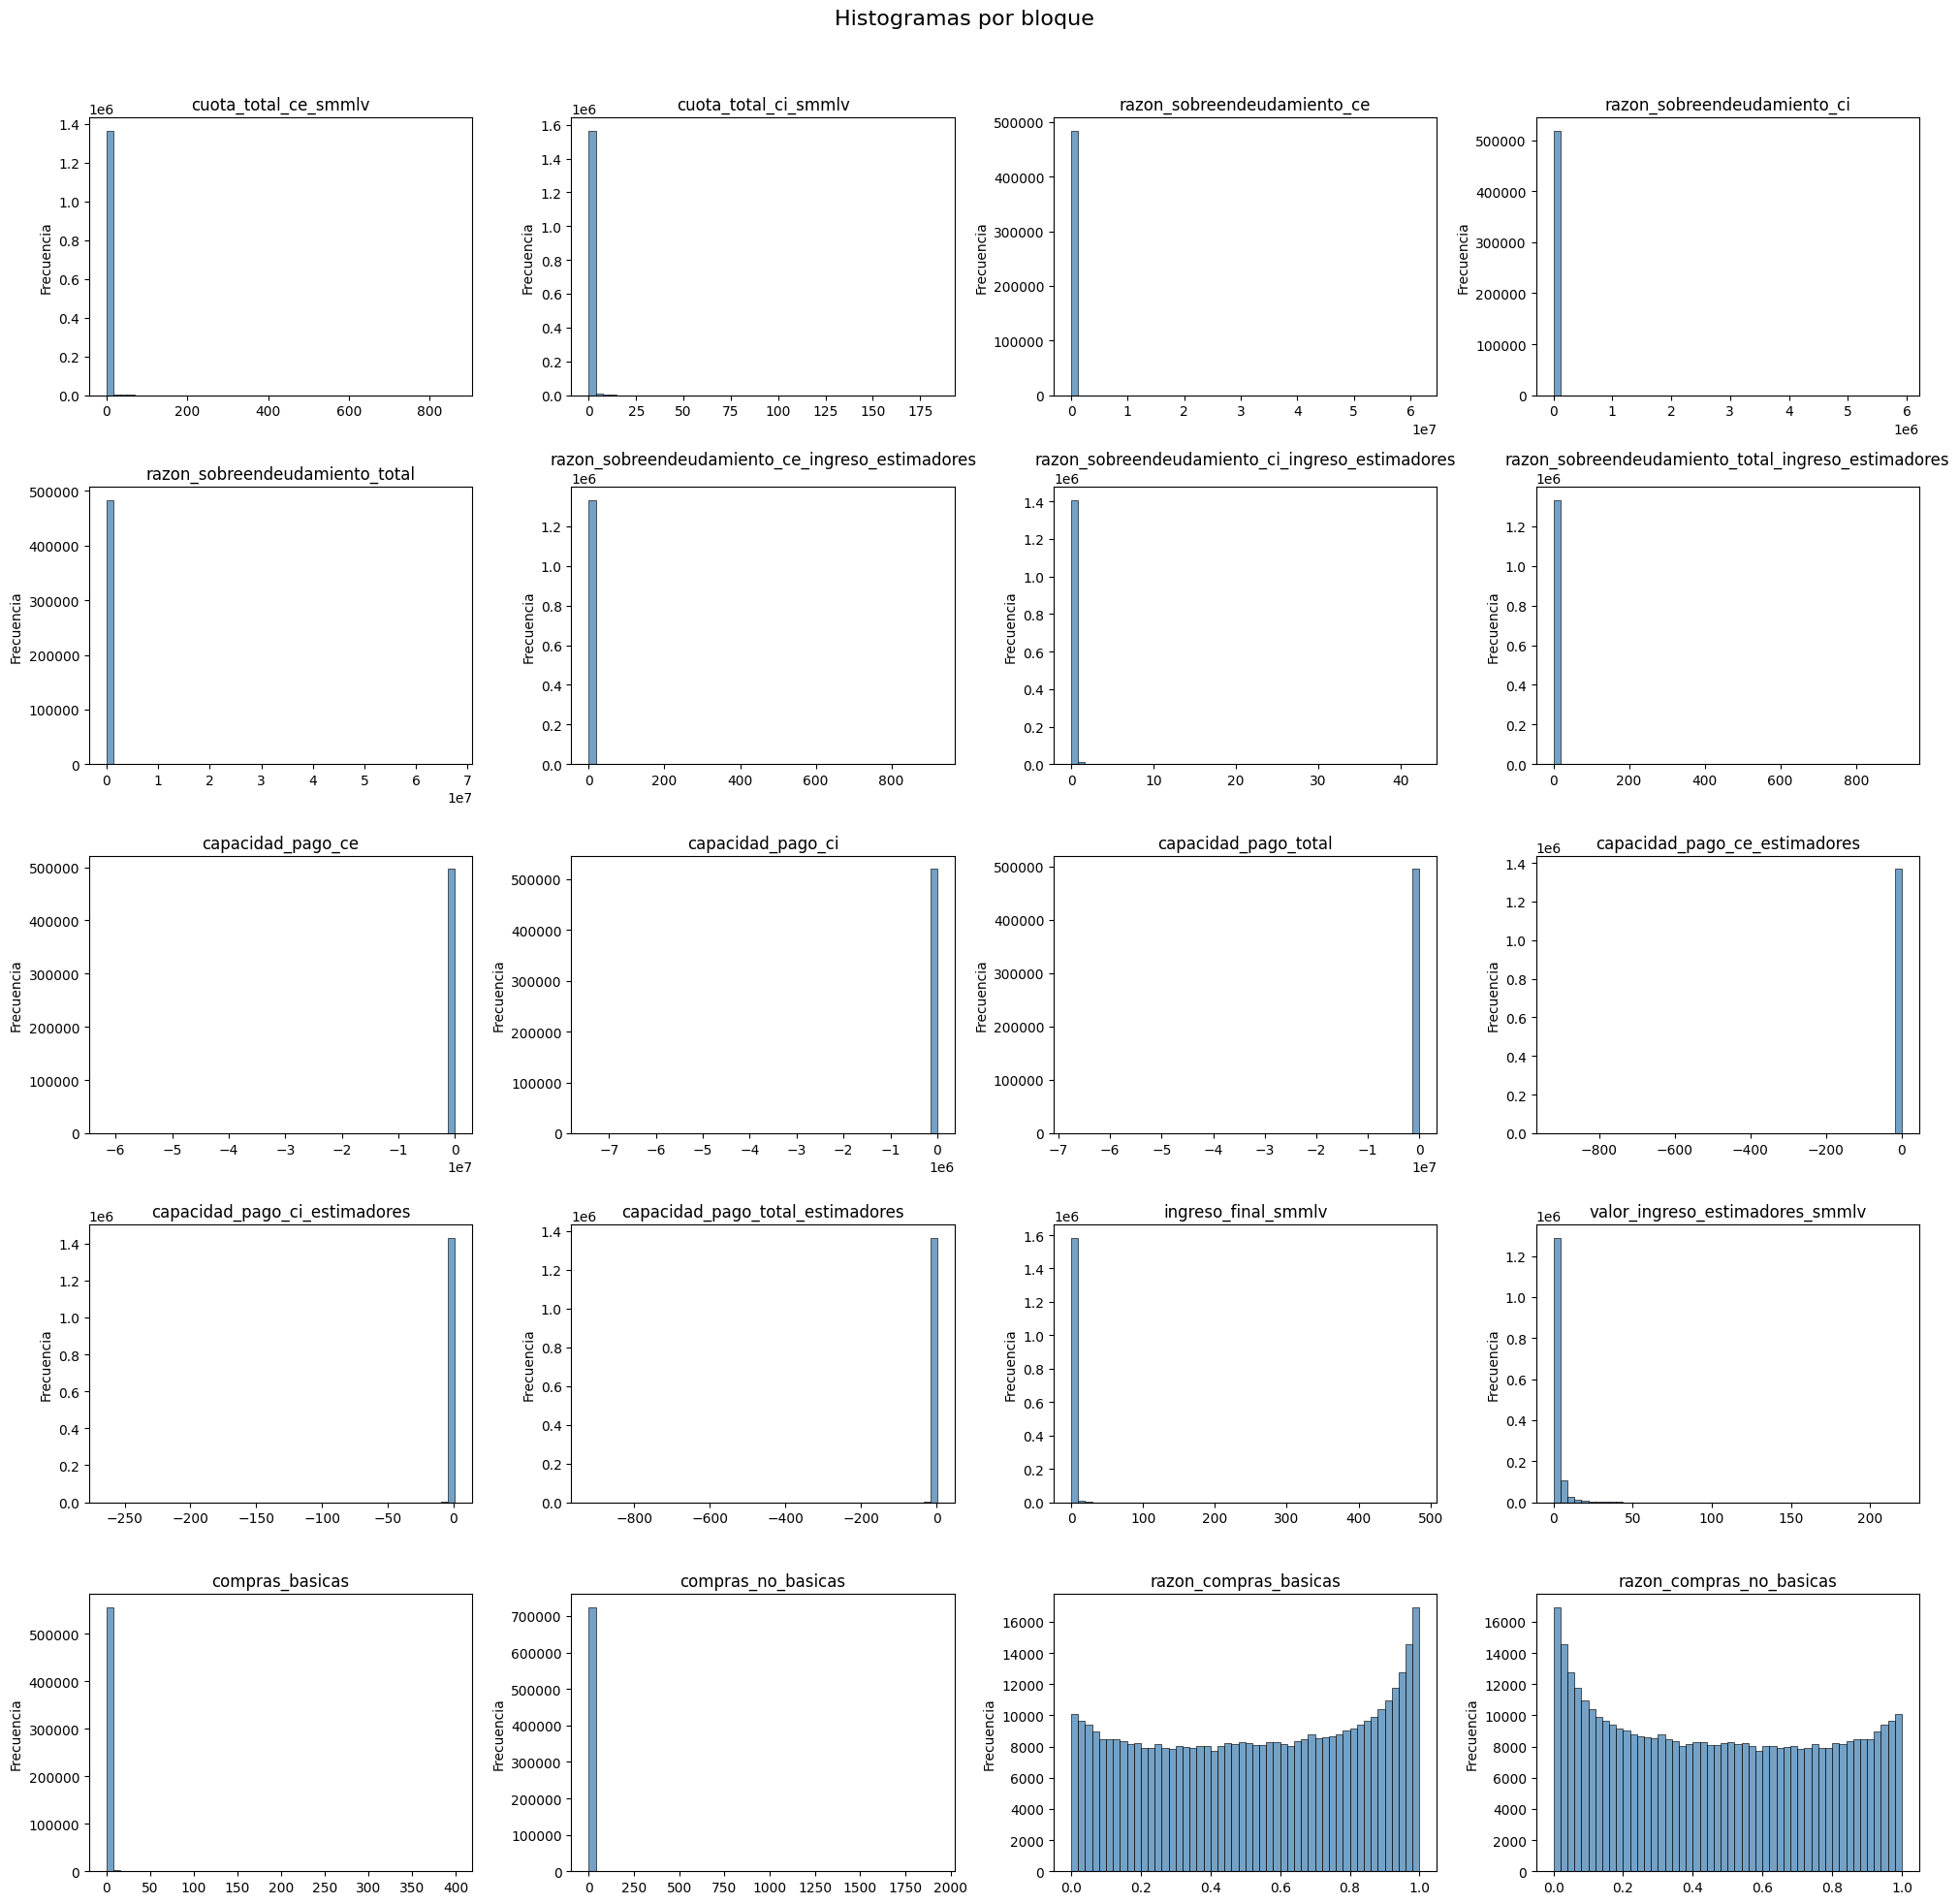

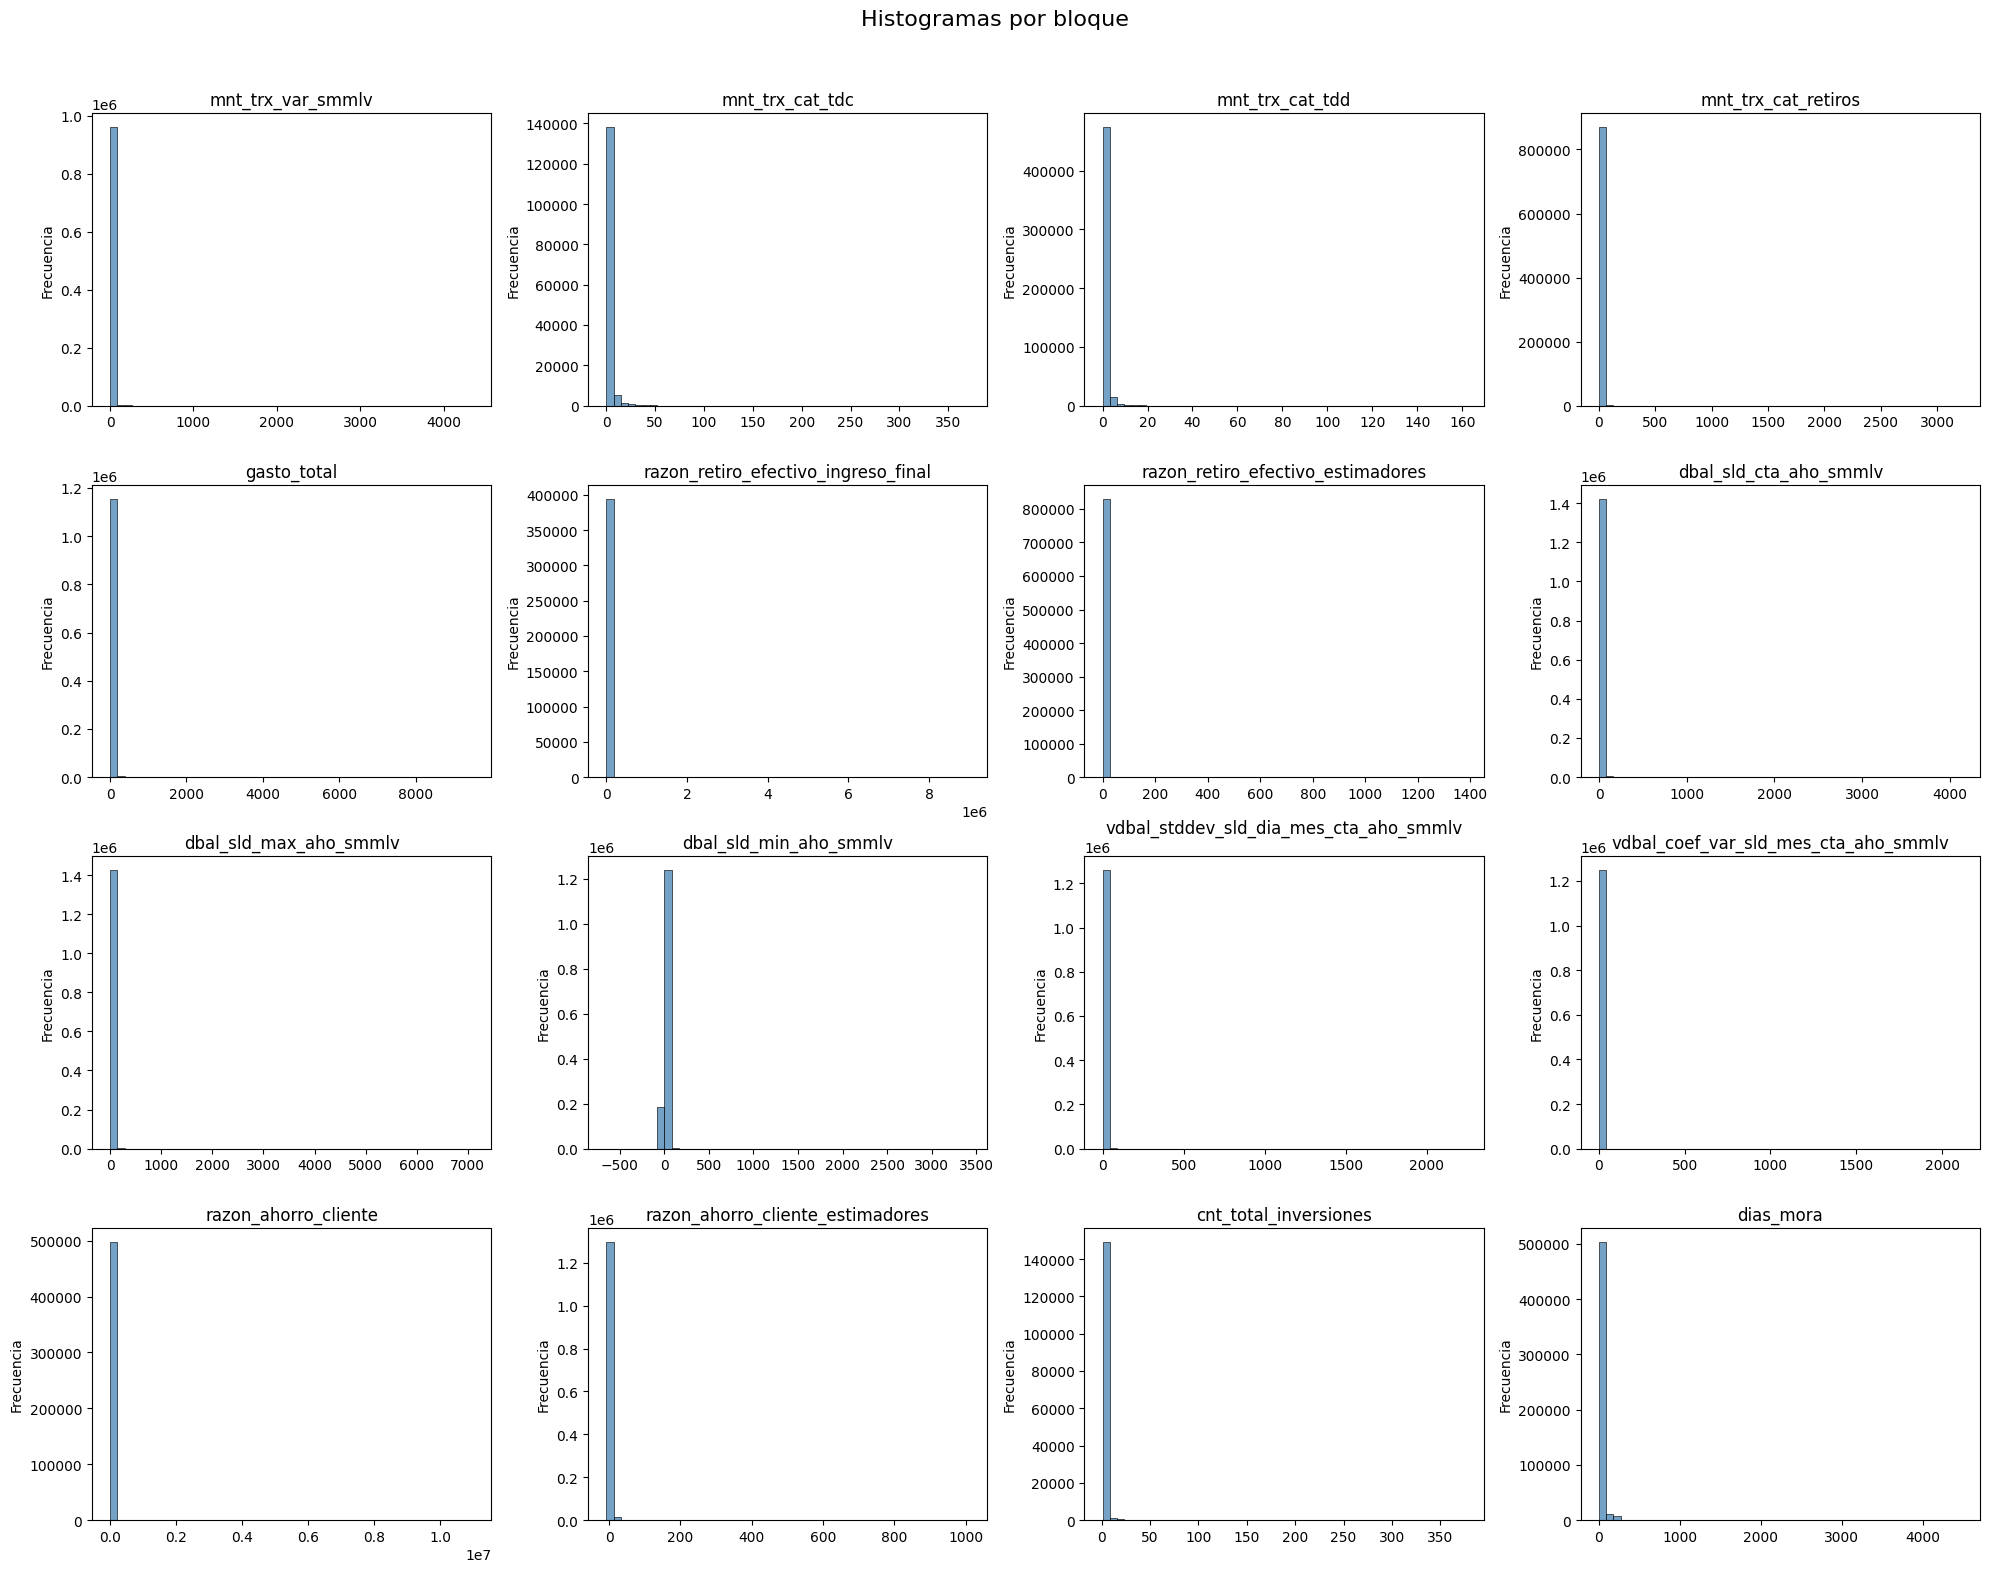

In [20]:
# Llamada a la función
graficar_histogramas_por_bloques(
    df=df_final,
    columnas=columnas_numericas,
    n_cols=4,
    por_bloque=20,
    bins=50
)

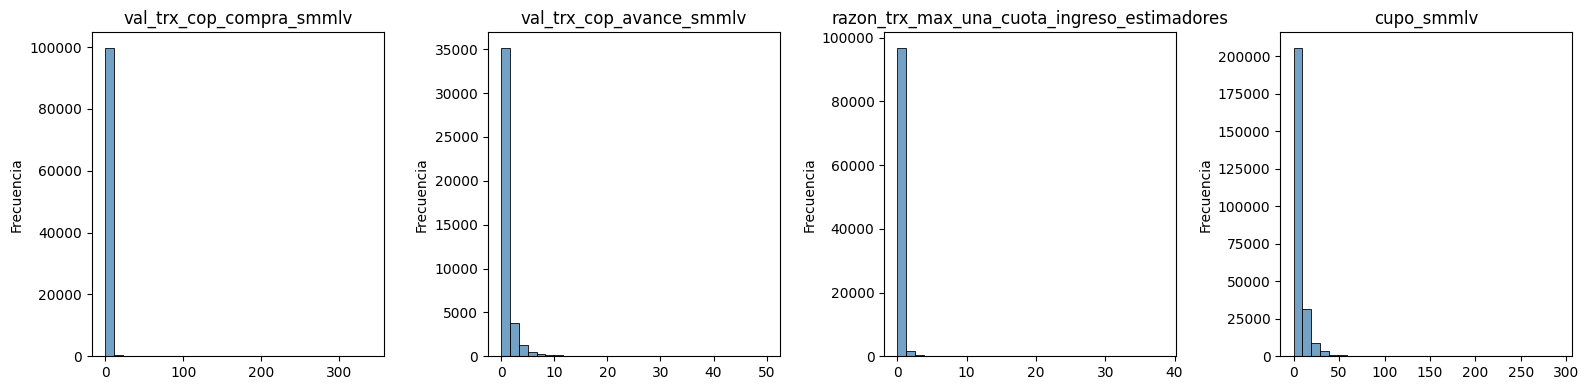

In [38]:
# Grafico de barras para 4 columnas que faltaron
plt.figure(figsize=(16, 4))
columnas = ['val_trx_cop_compra_smmlv',
        'val_trx_cop_avance_smmlv',
        'razon_trx_max_una_cuota_ingreso_estimadores', 'cupo_smmlv']
for i, col in enumerate(columnas):
    plt.subplot(1, 4, i + 1)
    sns.histplot(df_final[col], bins=30, kde=False, color='steelblue')
    plt.title(col)
    plt.xlabel("")
    plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

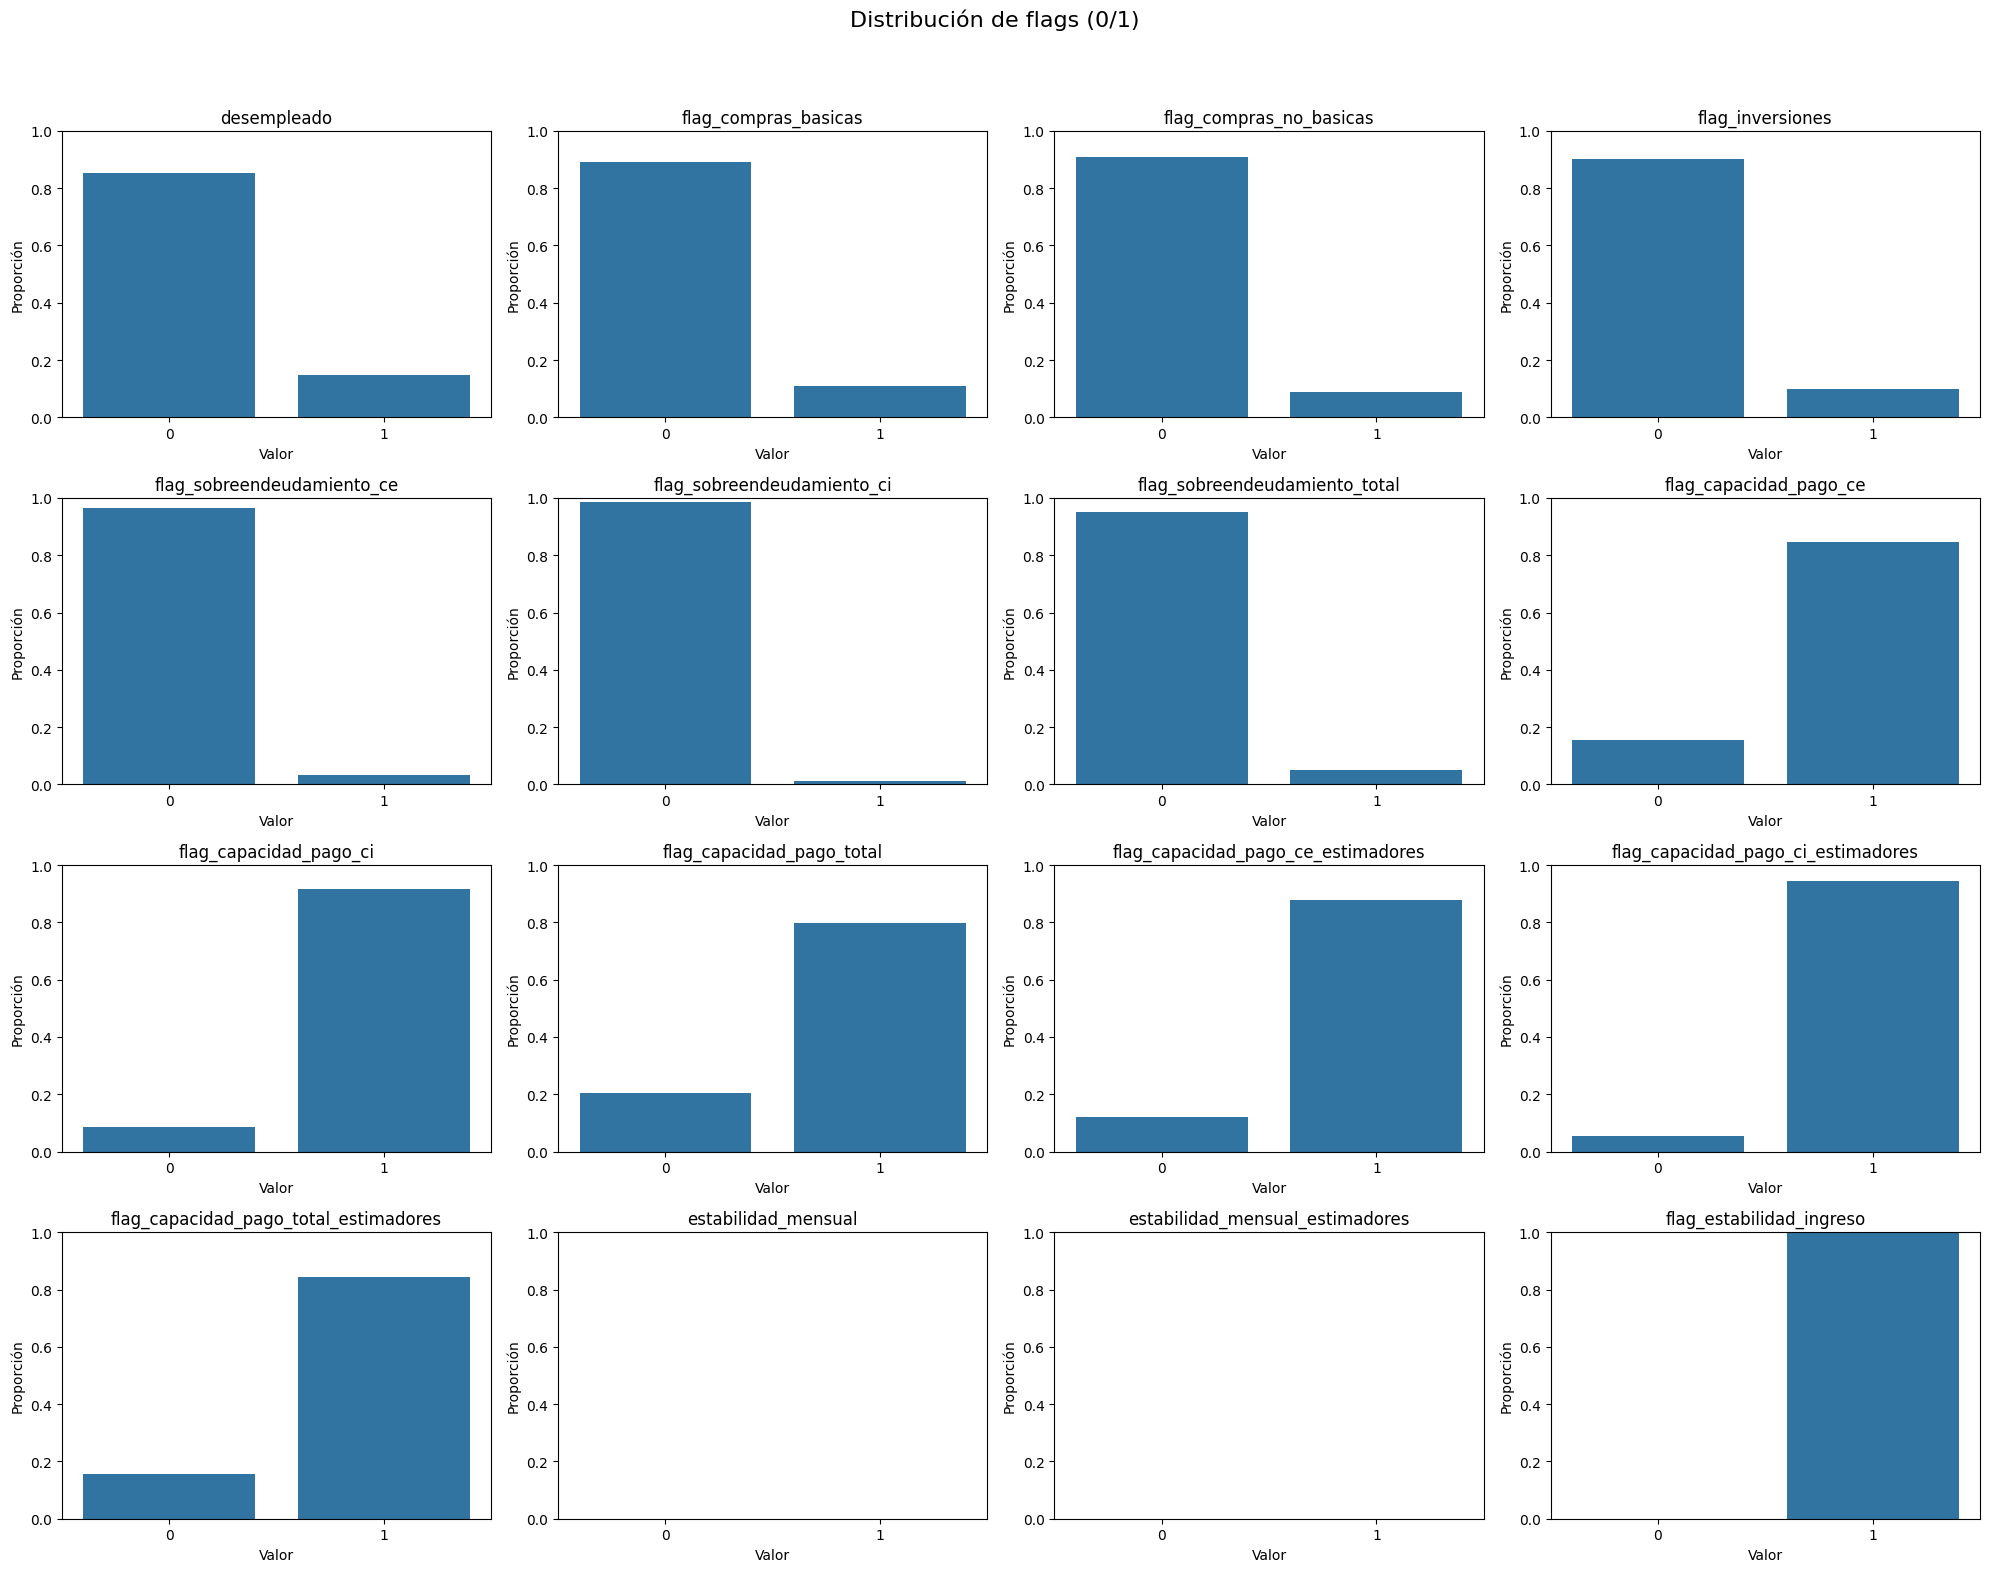

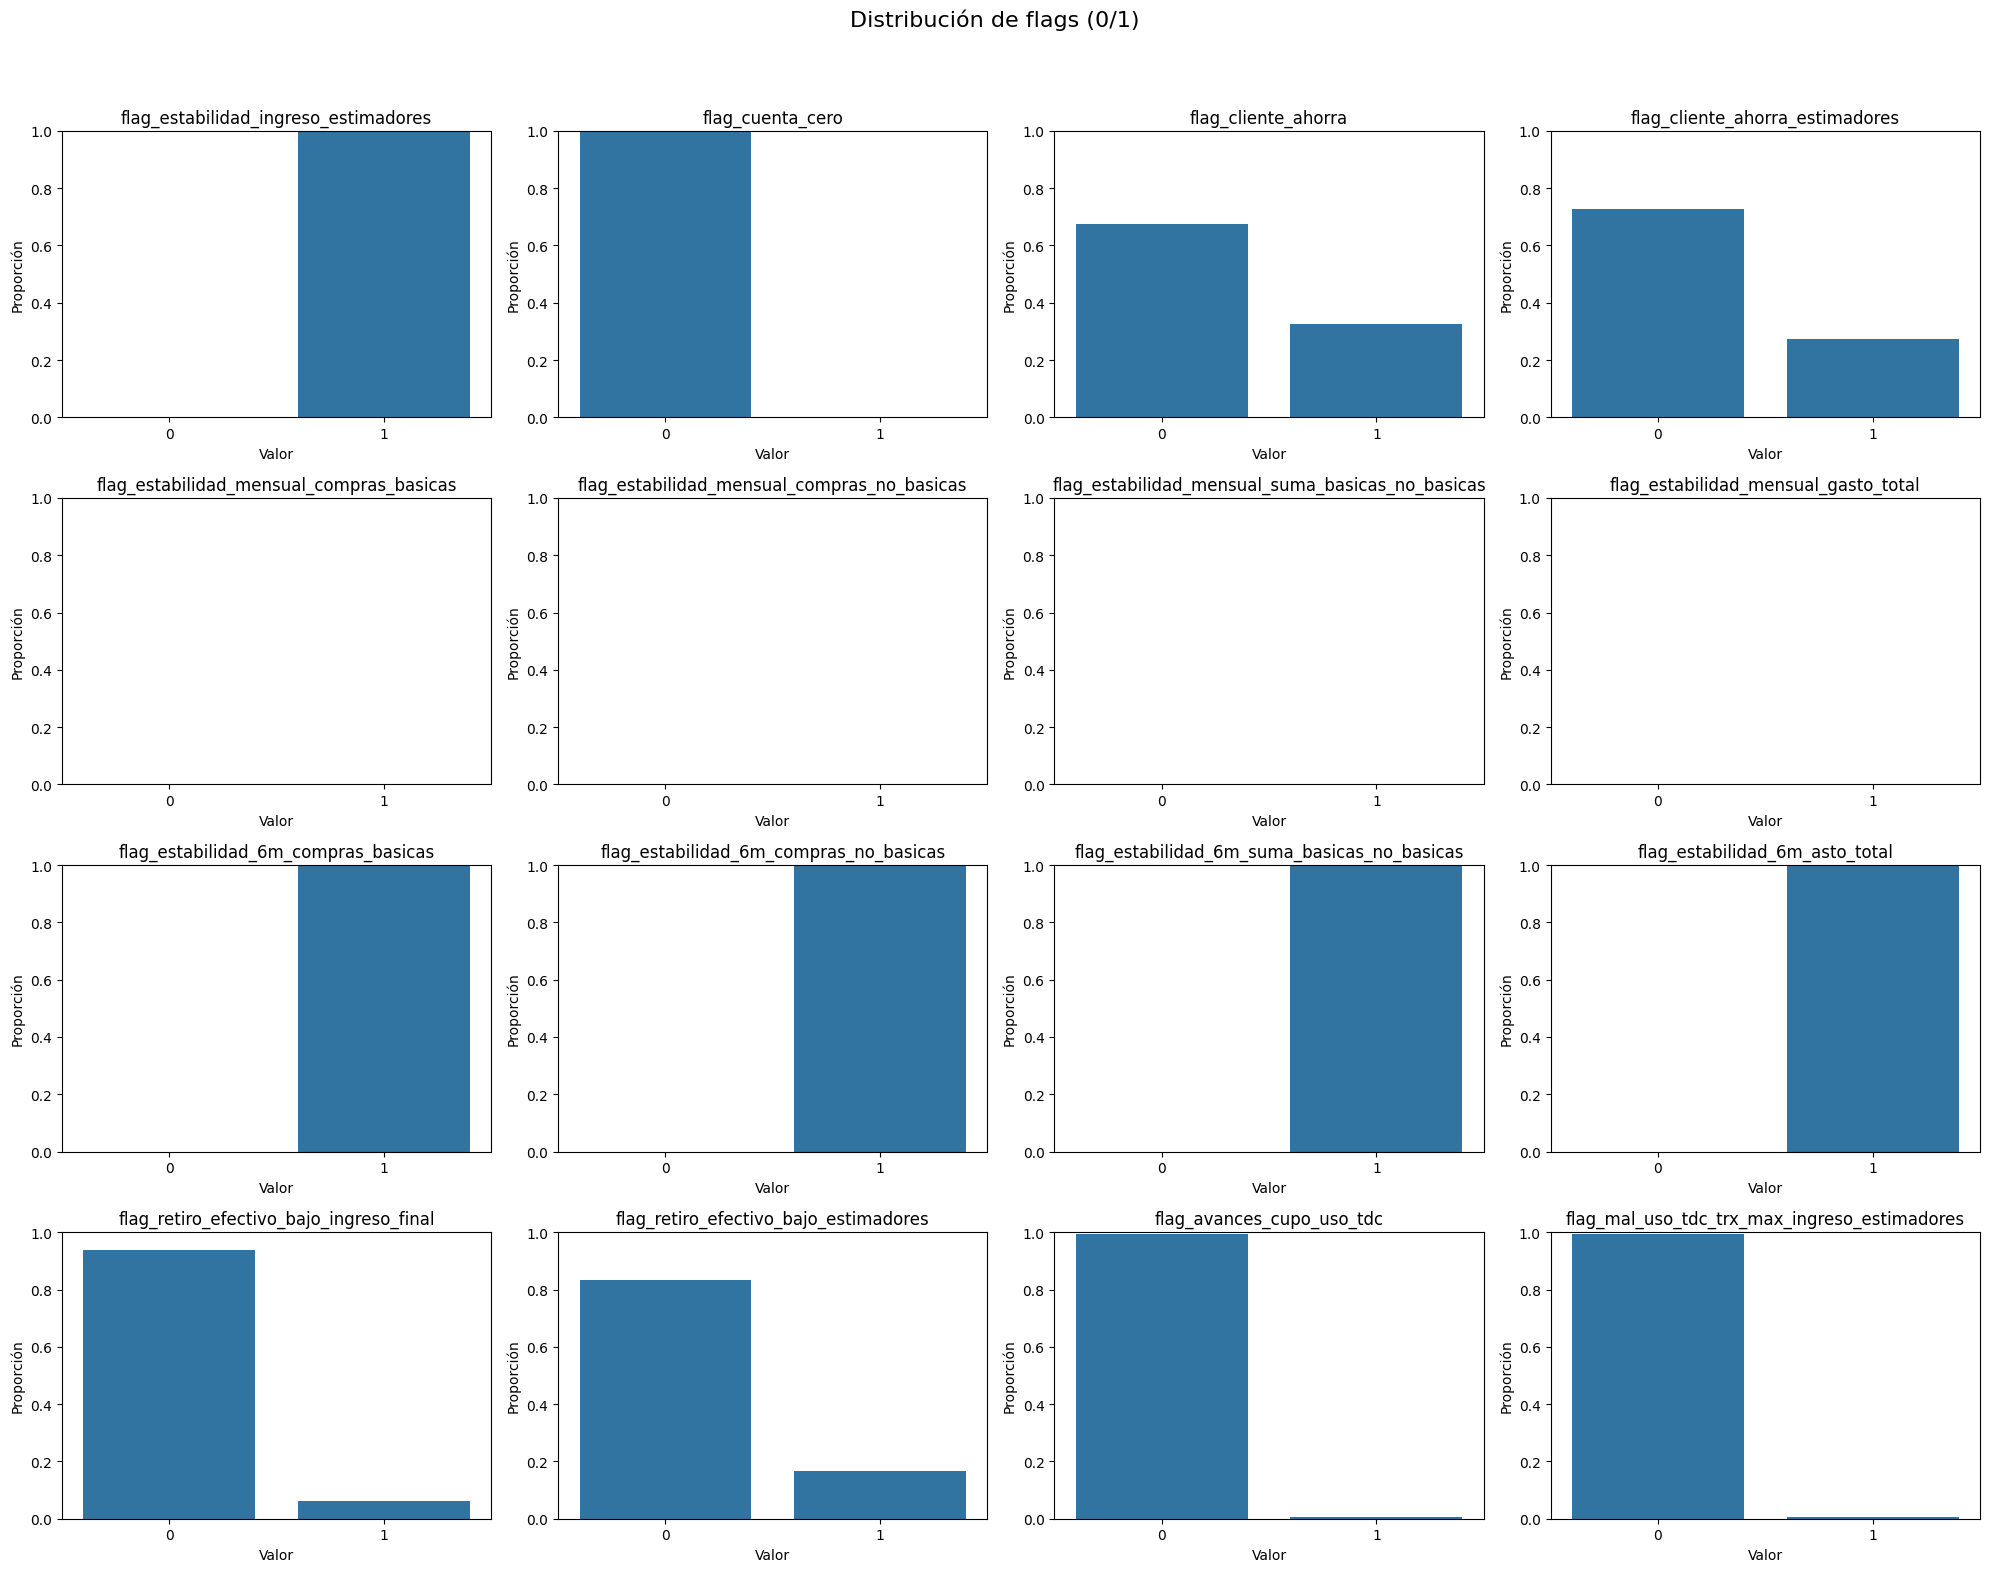

In [34]:
graficar_flags_dicotomicas(df_final, columnas_dicotomicas, por_bloque=16, n_cols=4)

### Descripción de estadísticos básicos en las columnas númericas

In [23]:
df_final[columnas_numericas].describe()

,cuota_total_ce_smmlv,cuota_total_ci_smmlv,razon_sobreendeudamiento_ce,razon_sobreendeudamiento_ci,razon_sobreendeudamiento_total,razon_sobreendeudamiento_ce_ingreso_estimadores,razon_sobreendeudamiento_ci_ingreso_estimadores,razon_sobreendeudamiento_total_ingreso_estimadores,capacidad_pago_ce,capacidad_pago_ci,...,razon_retiro_efectivo_estimadores,dbal_sld_cta_aho_smmlv,dbal_sld_max_aho_smmlv,dbal_sld_min_aho_smmlv,vdbal_stddev_sld_dia_mes_cta_aho_smmlv,vdbal_coef_var_sld_mes_cta_aho_smmlv,razon_ahorro_cliente,razon_ahorro_cliente_estimadores,cnt_total_inversiones,dias_mora
count,1.371211e+06,1.576640e+06,4.837130e+05,5.187440e+05,4.836920e+05,1.335223e+06,1.425364e+06,1.335151e+06,4.968960e+05,5.203240e+05,...,8.316750e+05,1.427981e+06,1.427981e+06,1.427981e+06,1.260538e+06,1.248135e+06,4.980050e+05,1.316170e+06,152692.000000,525024.000000
mean,7.501247e-01,1.769019e-01,2.337563e+02,3.696290e+01,2.734072e+02,3.158695e-01,6.110023e-02,3.807634e-01,-2.563593e+02,-6.431343e+01,...,1.142744e+00,2.414205e+00,3.981564e+00,1.207290e+00,8.061169e-01,1.367431e+00,9.334523e+01,9.757339e-01,1.986063,12.398327
std,5.266180e+00,9.710907e-01,9.215976e+04,1.214282e+04,1.012896e+05,2.459053e+00,2.556014e-01,2.482214e+00,9.200066e+04,1.512503e+04,...,3.996777e+00,1.550493e+01,2.213195e+01,1.078068e+01,5.797825e+00,3.683259e+00,2.107287e+04,5.458348e+00,5.997925,72.085059
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-6.160500e+07,-7.429727e+06,...,9.041591e-09,-6.855490e+00,-5.836500e-01,-6.520590e+02,0.000000e+00,0.000000e+00,-1.514500e+03,-7.824811e+00,1.000000,0.000000
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.136728e-01,7.689141e-01,...,2.352941e-01,6.280000e-03,2.664000e-02,-8.700000e-04,2.512000e-02,3.076167e-01,2.982640e-02,7.005298e-03,1.000000,0.000000
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.943751e-02,0.000000e+00,0.000000e+00,0.000000e+00,9.028260e-01,9.694210e-01,...,6.329547e-01,1.031100e-01,6.366500e-01,4.900000e-04,1.840500e-01,9.877024e-01,1.338587e-01,7.782082e-02,1.000000,0.000000
75%,2.603448e-01,0.000000e+00,1.988921e-01,2.896981e-02,3.639603e-01,1.328883e-01,0.000000e+00,2.674662e-01,1.000000e+00,1.000000e+00,...,1.223217e+00,7.418700e-01,2.290780e+00,2.134000e-02,5.589000e-01,1.895703e+00,5.283600e-01,3.875395e-01,1.000000,1.000000
max,8.627698e+02,1.840604e+02,6.160500e+07,5.918346e+06,6.752335e+07,9.212567e+02,4.232705e+01,9.212567e+02,1.000000e+00,1.000000e+00,...,1.382058e+03,4.140199e+03,7.103069e+03,3.423263e+03,2.238336e+03,2.115000e+03,1.099957e+07,1.010224e+03,376.000000,4480.000000


### Gráficas Boxplots para columnas númericas

In [36]:
def graficar_boxplots_por_bloques(
    df: pd.DataFrame,
    columnas: list,
    n_cols: int = 4,
    por_bloque: int = 20,
    sample_size: int = 10_000_000
) -> None:
    """
    Grafica boxplots por bloques para columnas numéricas.

    Args:
        df (pd.DataFrame): DataFrame con los datos.
        columnas (list): Lista de nombres de columnas numéricas.
        n_cols (int): Número de columnas por fila.
        por_bloque (int): Número de boxplots por bloque de visualización.
        sample_size (int): Tamaño máximo de muestra para acelerar gráficas.
    """
    # Muestreo si el DataFrame es muy grande
    if sample_size and len(df) > sample_size:
        df = df.sample(n=sample_size, random_state=42)

    # Filtrar solo columnas numéricas
    columnas = [col for col in columnas if pd.api.types.is_numeric_dtype(df[col])]

    total = len(columnas)
    for start in range(0, total, por_bloque):
        sub_cols = columnas[start:start + por_bloque]
        n = len(sub_cols)
        n_rows = -(-n // n_cols)

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
        axes = axes.flatten()

        for i, col in enumerate(sub_cols):
            sns.boxplot(y=df[col], ax=axes[i], color='skyblue')
            axes[i].set_title(f"{col}")
            axes[i].set_xlabel("")
            axes[i].set_ylabel("")

        # Ocultar ejes vacíos
        for j in range(i + 1, len(axes)):
            axes[j].set_visible(False)

        plt.suptitle("Boxplots por bloque", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()


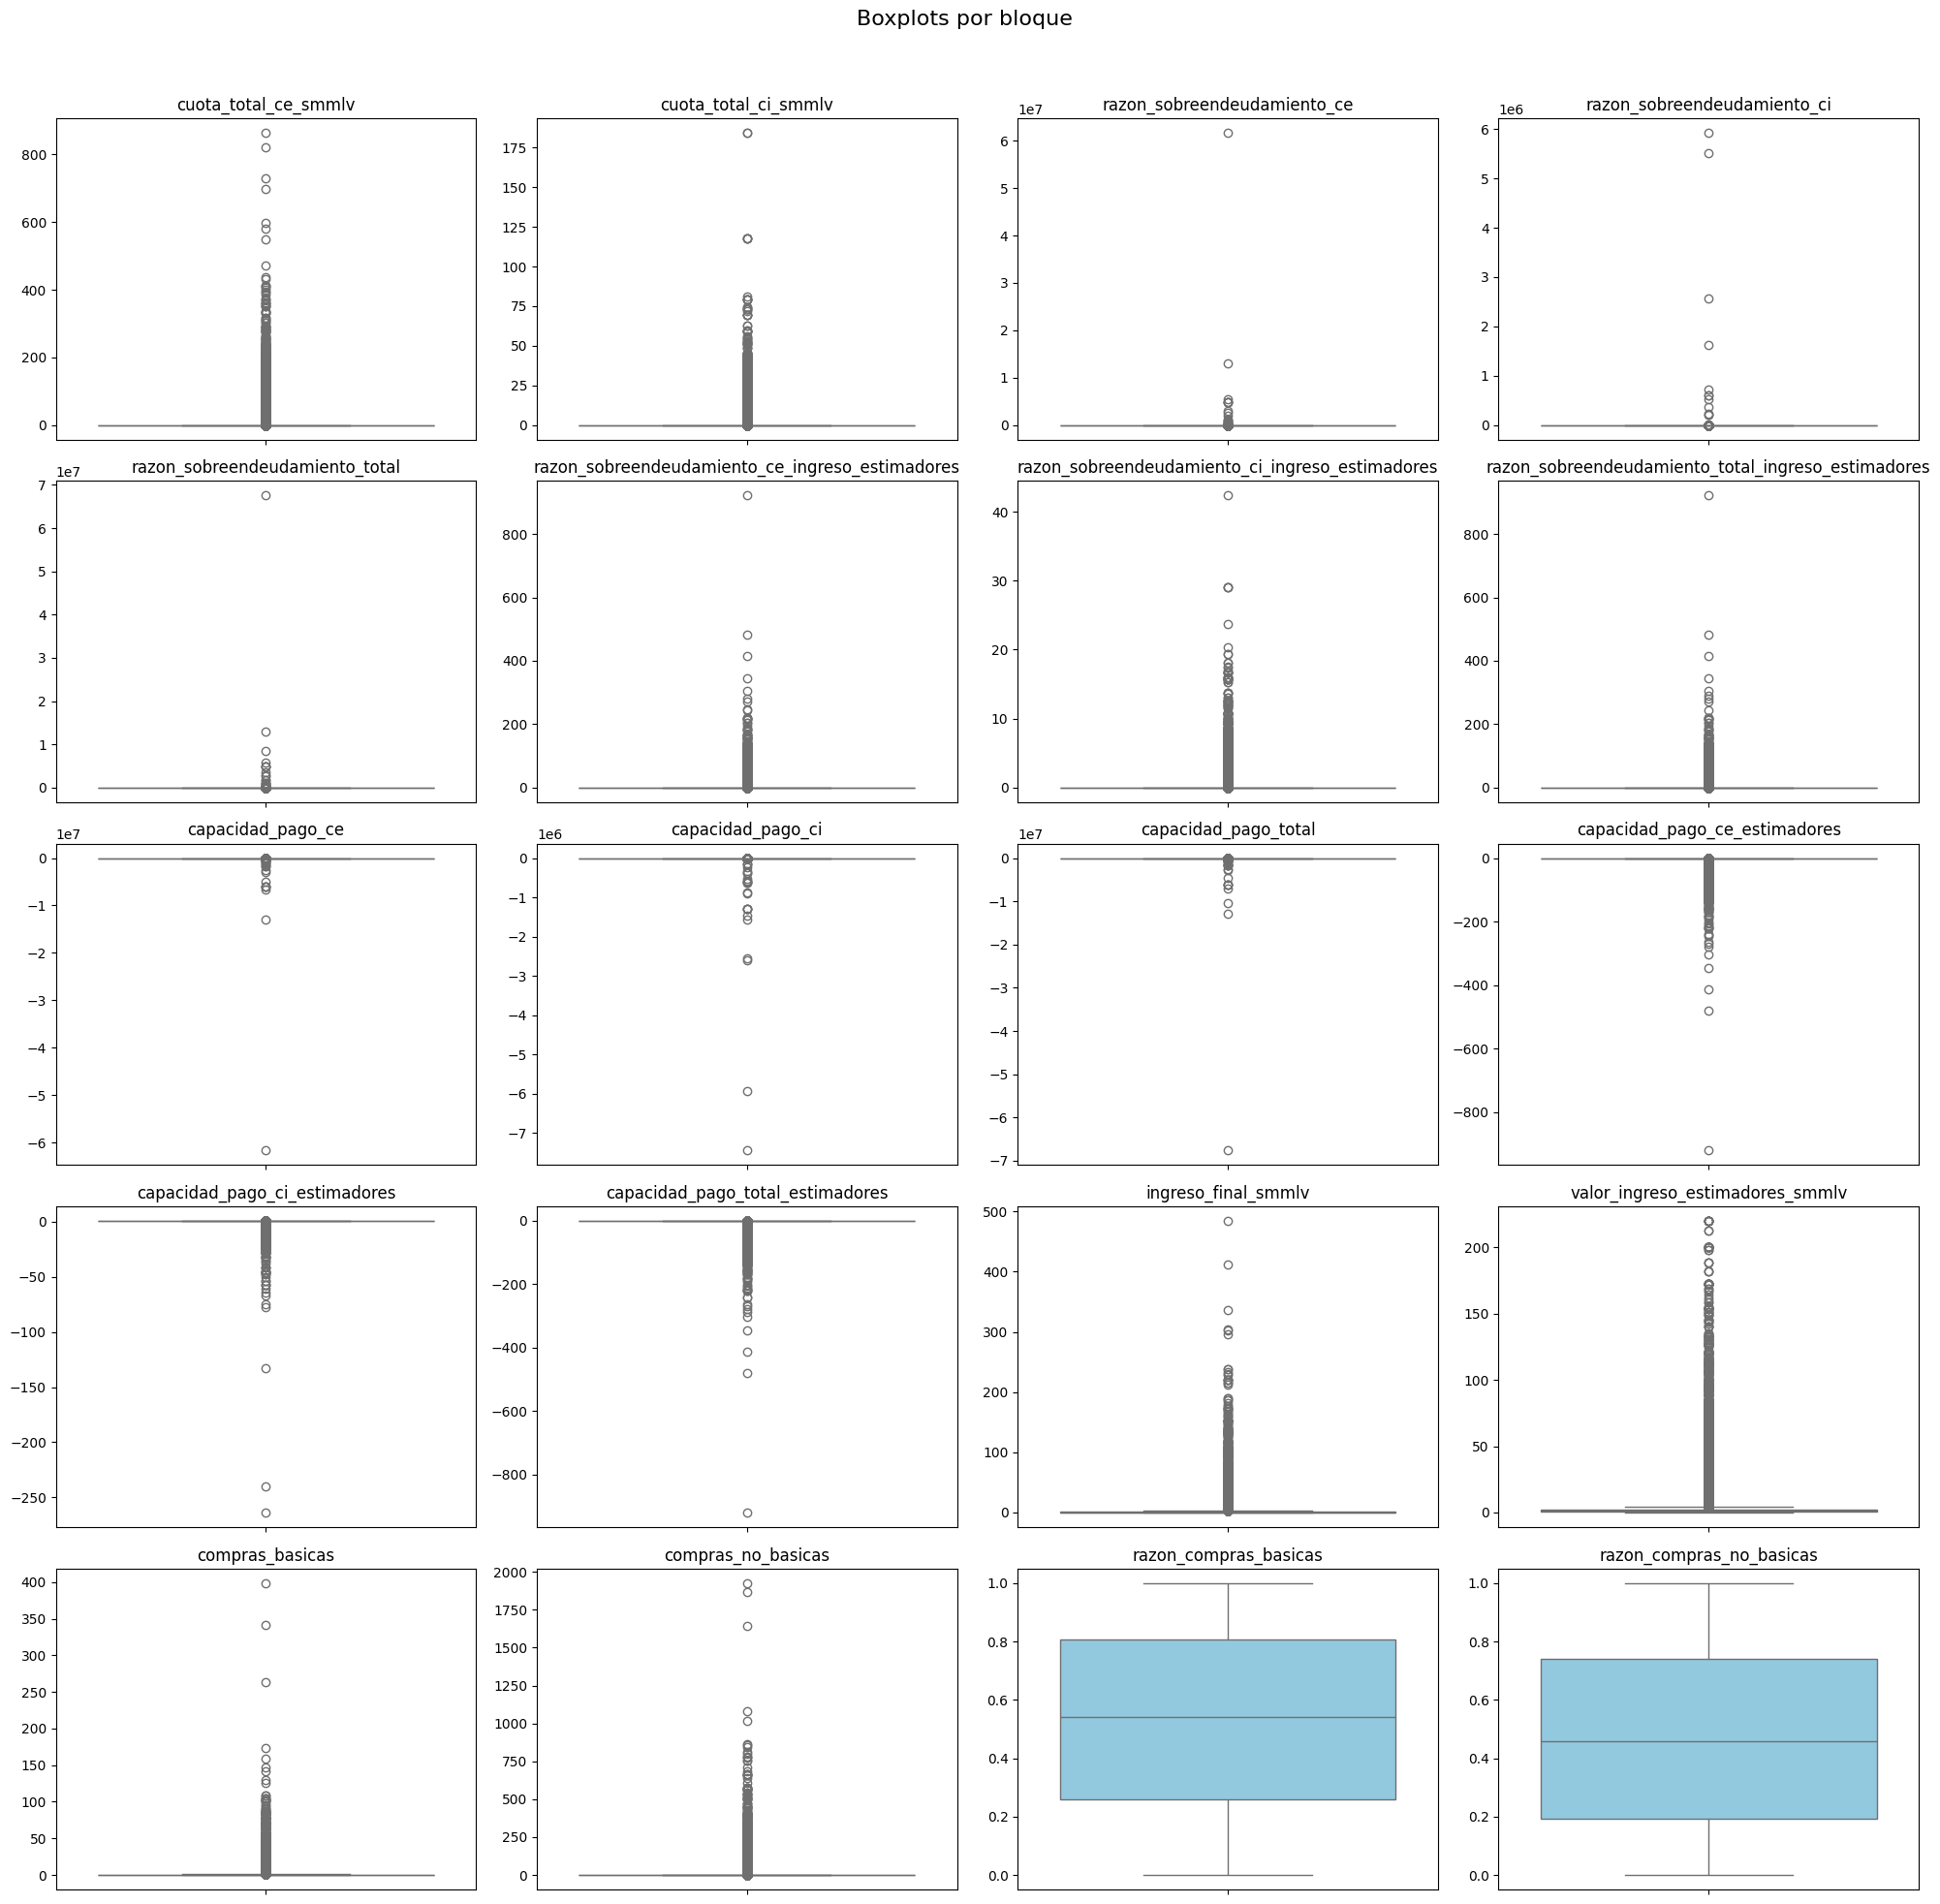

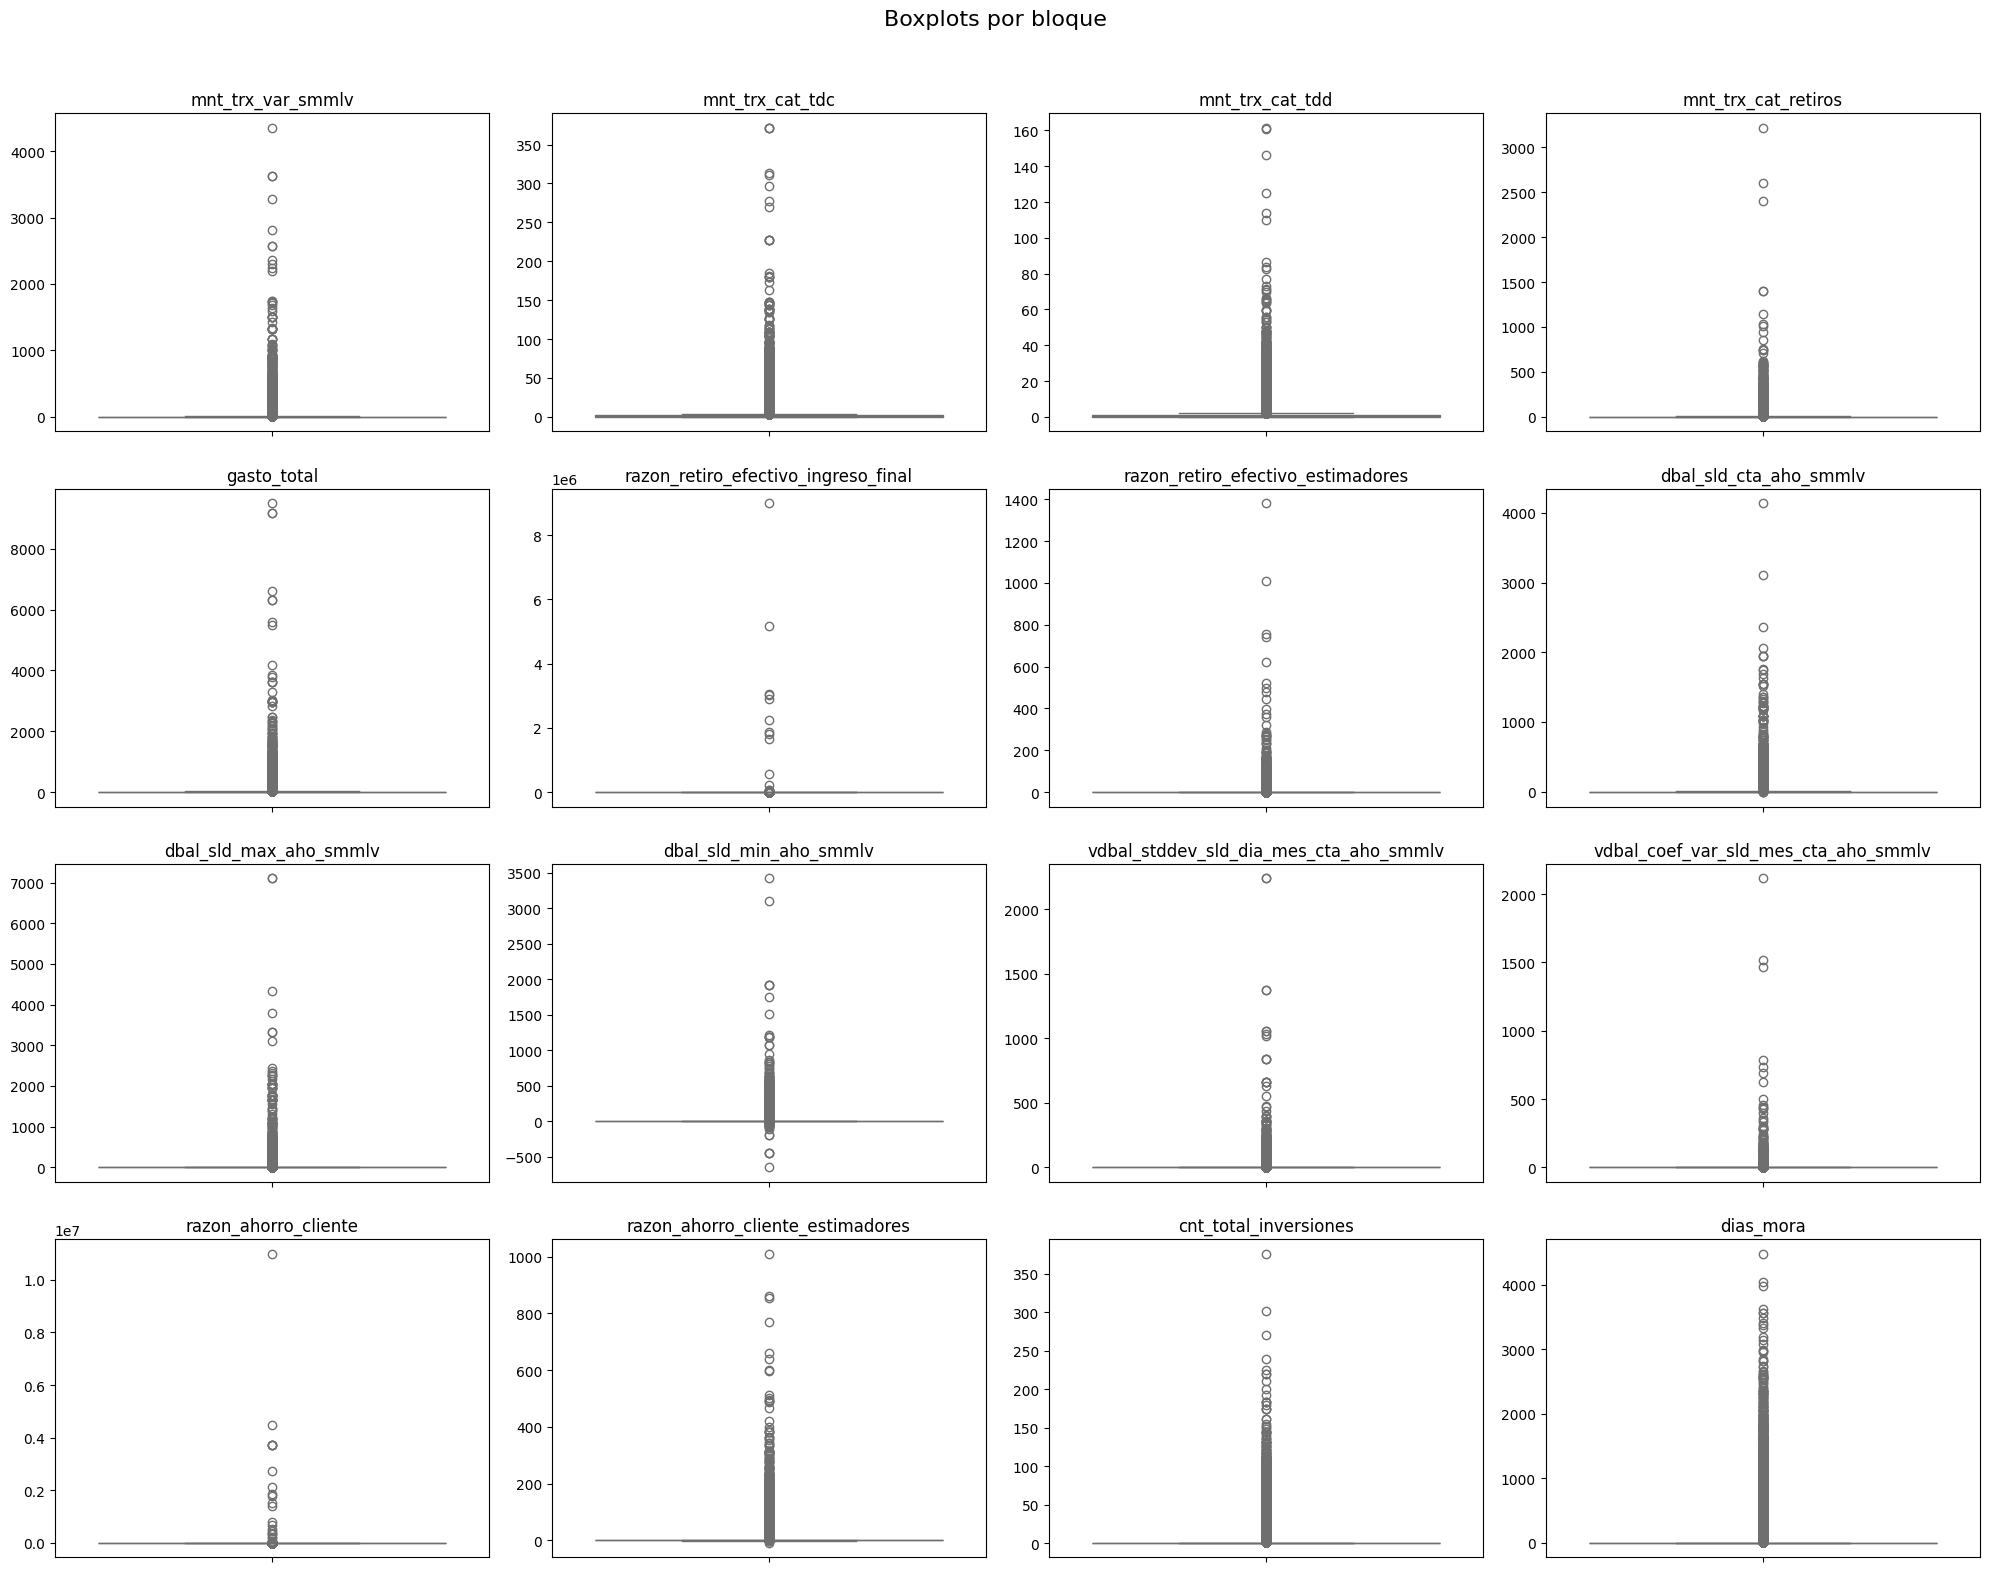

In [37]:
graficar_boxplots_por_bloques(
    df=df_final,
    columnas=columnas_numericas,
    n_cols=4,
    por_bloque=20
)

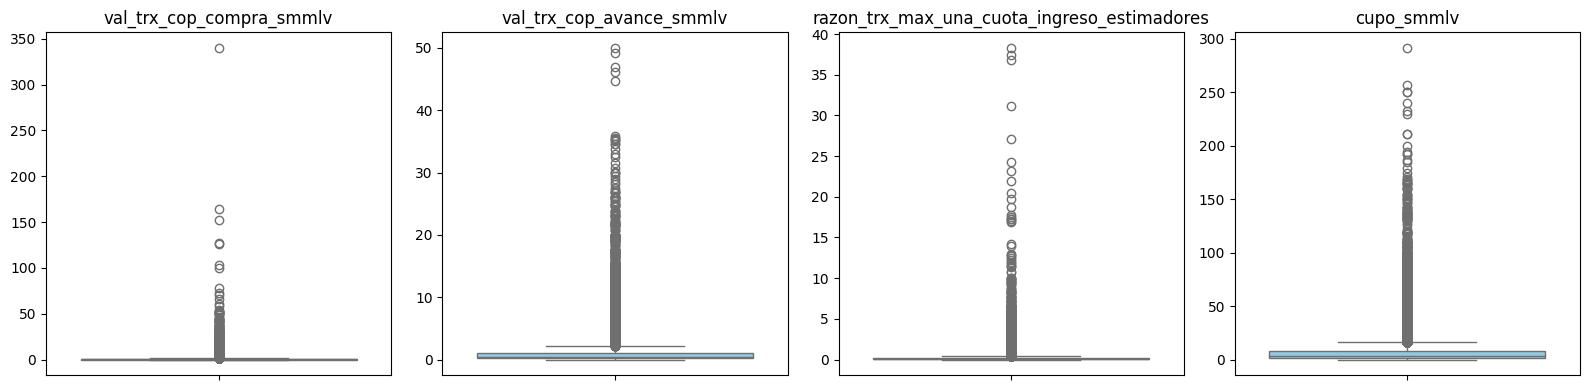

In [39]:
# Grafico de boxplots para 4 columnas que faltaron
plt.figure(figsize=(16, 4))
columnas = [
    'val_trx_cop_compra_smmlv',
    'val_trx_cop_avance_smmlv',
    'razon_trx_max_una_cuota_ingreso_estimadores',
    'cupo_smmlv'
]

for i, col in enumerate(columnas):
    plt.subplot(1, 4, i + 1)
    sns.boxplot(y=df_final[col], color='skyblue')
    plt.title(col)
    plt.xlabel("")
    plt.ylabel("")

plt.tight_layout()
plt.show()